# 基于Position_Embedding和 Attention机制进行文本分类

注意力机制即 Attention mechanism在序列学习任务上具有巨大的提升作用，在编解码器框架内，通过在编码段加入Attention模型，对源数据序列进行数据加权变换，或者在解码端引入Attention 模型，对目标数据进行加权变化，可以有效提高序列对序列的自然方式下的系统表现。

### 什么是Attention： 
Attention模型的基本表述可以这样理解成： 当我们人在看一样东西的时候，我们当前时刻关注的一定是我们当前正在看的这样东西的某一地方，换句话说，当我们目光移到别处时，注意力随着目光的移动也在转移。 这意味着，当人们注意到某个目标或某个场景时，该目标内部以及该场景内每一处空间位置上的注意力分布是不一样的。 这一点在如下情形下同样成立：当我们试图描述一件事情，我们当前时刻说到的单词和句子和正在描述的该事情的对应某个片段最先关，而其他部分随着描述的进行，相关性也在不断地改变。

从上面两种情形来看，对于 Attention的作用角度出发，我们就可以从两个角度来分类 Attention种类： 空间注意力 Spatial Attention 时间注意力 Temporal Attention 这样的分类更多的是从应用层面上，而从 Attention的作用方法上，可以将其分为 Soft Attention 和 Hard Attention，这既我们所说的， Attention输出的向量分布是一种one-hot的独热分布还是soft的软分布，这直接影响对于上下文信息的选择作用。

### 为什么要加入Attention： 
当输入序列非常长时，模型难以学到合理的向量表示 序列输入时，随着序列的不断增长，原始根据时间步的方式的表现越来越差，这是由于原始的这种时间步模型设计的结构有缺陷，即所有的上下文输入信息都被限制到固定长度，整个模型的能力都同样收到限制，我们暂且把这种原始的模型称为简单的编解码器模型。 编解码器的结构无法解释，也就导致了其无法设计。

### 长输入序列带来的问题： 
使用传统编码器-解码器的RNN模型先用一些LSTM单元来对输入序列进行学习，编码为固定长度的向量表示；然后再用一些LSTM单元来读取这种向量表示并解码为输出序列。 采用这种结构的模型在许多比较难的序列预测问题（如文本翻译）上都取得了最好的结果，因此迅速成为了目前的主流方法。 这种结构在很多其他的领域上也取得了不错的结果。然而，它存在一个问题在于：输入序列不论长短都会被编码成一个固定长度的向量表示，而解码则受限于该固定长度的向量表示。 这个问题限制了模型的性能，尤其是当输入序列比较长时，模型的性能会变得很差（在文本翻译任务上表现为待翻译的原始文本长度过长时翻译质量较差）。

“一个潜在的问题是，采用编码器-解码器结构的神经网络模型需要将输入序列中的必要信息表示为一个固定长度的向量，而当输入序列很长时则难以保留全部的必要信息（因为太多），尤其是当输入序列的长度比训练数据集中的更长时。” — Dzmitry Bahdanau, et al., Neural machine translation by jointly learning to align and translate, 2015

### 如何使用Attention机制：
Attention机制的基本思想是：打破了传统编码器-解码器结构在编解码时都依赖于内部一个固定长度向量的限制。 Attention机制的实现是 通过保留LSTM编码器对输入序列的中间输出结果，然后训练一个模型来对这些输入进行选择性的学习并且在模型输出时将输出序列与之进行关联。

换一个角度而言，输出序列中的每一项的生成概率取决于在输入序列中选择了哪些项。

Attention-based Model 其实就是一个相似性的度量，当前的输入与目标状态约相似，那么在当前的输入的权重就会越大。就是在原有的model上加入了Attention的思想。

**没有attention机制的encoder-decoder结构通常把encoder的最后一个状态作为decoder的输入（可能作为初始化，也可能作为每一时刻的输入），但是encoder的state毕竟是有限的，存储不了太多的信息，对于decoder过程，每一个步骤都和之前的输入都没有关系了，只与这个传入的state有关。attention机制的引入之后，decoder根据时刻的不同，让每一时刻的输入都有所不同。**


In [1]:
import os
os.listdir('../input')

['wiki-news-300d-1M.vec.zip',
 'test.csv',
 'crawl-300d-2M.vec.zip',
 'train.csv',
 'sample_submission.csv']

In [2]:
import pandas as pd
import numpy as np

In [3]:
np.random.seed(42)

In [4]:
# read data to dataframe
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

print('train shape {} rows, {} cols'.format(*df_train.shape))
print('test shape {} rows, {} cols'.format(*df_test.shape))

train shape 159571 rows, 8 cols
test shape 153164 rows, 2 cols


In [5]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [7]:
for label in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
  print(label)
  print(df_train[label].value_counts())
  print('*'*80)

toxic
0    144277
1     15294
Name: toxic, dtype: int64
********************************************************************************
severe_toxic
0    157976
1      1595
Name: severe_toxic, dtype: int64
********************************************************************************
obscene
0    151122
1      8449
Name: obscene, dtype: int64
********************************************************************************
threat
0    159093
1       478
Name: threat, dtype: int64
********************************************************************************
insult
0    151694
1      7877
Name: insult, dtype: int64
********************************************************************************
identity_hate
0    158166
1      1405
Name: identity_hate, dtype: int64
********************************************************************************


In [8]:
from keras.preprocessing import text, sequence

Using TensorFlow backend.


In [9]:
X_train = df_train["comment_text"].fillna("fillna").values
target_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = df_train[target_cols].values
X_test = df_test["comment_text"].fillna("fillna").values

In [10]:
max_features = 30000
maxlen = 100
embed_size = 300

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train) + list(X_test))

X_train = tokenizer.texts_to_sequences(X_train)
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)

X_test = tokenizer.texts_to_sequences(X_test)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [11]:
from keras import backend as K
from keras.engine.topology import Layer
from keras.models import Model
from keras.layers import *


class Position_Embedding(Layer):

  def __init__(self, size=None, mode='sum', **kwargs):
    self.size = size  # 必须为偶数
    self.mode = mode
    super(Position_Embedding, self).__init__(**kwargs)

  def call(self, x):
    if (self.size == None) or (self.mode == 'sum'):
      self.size = int(x.shape[-1])
    batch_size, seq_len = K.shape(x)[0], K.shape(x)[1]
    position_j = 1. / K.pow(10000., 2 * K.arange(self.size / 2, dtype='float32') / self.size)
    position_j = K.expand_dims(position_j, 0)
    position_i = K.cumsum(K.ones_like(x[:, :, 0]),
                          1) - 1  # K.arange不支持变长，只好用这种方法生成
    position_i = K.expand_dims(position_i, 2)
    position_ij = K.dot(position_i, position_j)
    position_ij = K.concatenate([K.cos(position_ij), K.sin(position_ij)], 2)
    if self.mode == 'sum':
      return position_ij + x
    elif self.mode == 'concat':
      return K.concatenate([position_ij, x], 2)

  def compute_output_shape(self, input_shape):
    if self.mode == 'sum':
      return input_shape
    elif self.mode == 'concat':
      return (input_shape[0], input_shape[1], input_shape[2] + self.size)

In [12]:
class Attention(Layer):

  def __init__(self, nb_head, size_per_head, **kwargs):
    self.nb_head = nb_head
    self.size_per_head = size_per_head
    self.output_dim = nb_head * size_per_head
    super(Attention, self).__init__(**kwargs)

  def build(self, input_shape):
    self.WQ = self.add_weight(
        name='WQ',
        shape=(input_shape[0][-1], self.output_dim),
        initializer='glorot_uniform',
        trainable=True)
    self.WK = self.add_weight(
        name='WK',
        shape=(input_shape[1][-1], self.output_dim),
        initializer='glorot_uniform',
        trainable=True)
    self.WV = self.add_weight(
        name='WV',
        shape=(input_shape[2][-1], self.output_dim),
        initializer='glorot_uniform',
        trainable=True)
    super(Attention, self).build(input_shape)

  def Mask(self, inputs, seq_len, mode='mul'):
    if seq_len == None:
      return inputs
    else:
      mask = K.one_hot(seq_len[:, 0], K.shape(inputs)[1])
      mask = 1 - K.cumsum(mask, 1)
      for _ in range(len(inputs.shape) - 2):
        mask = K.expand_dims(mask, 2)
      if mode == 'mul':
        return inputs * mask
      if mode == 'add':
        return inputs - (1 - mask) * 1e12

  def call(self, x):
    # 如果只传入Q_seq,K_seq,V_seq，那么就不做Mask
    # 如果同时传入Q_seq,K_seq,V_seq,Q_len,V_len，那么对多余部分做Mask
    if len(x) == 3:
      Q_seq, K_seq, V_seq = x
      Q_len, V_len = None, None
    elif len(x) == 5:
      Q_seq, K_seq, V_seq, Q_len, V_len = x
    # 对Q、K、V做线性变换
    Q_seq = K.dot(Q_seq, self.WQ)
    Q_seq = K.reshape(Q_seq,
                      (-1, K.shape(Q_seq)[1], self.nb_head, self.size_per_head))
    Q_seq = K.permute_dimensions(Q_seq, (0, 2, 1, 3))
    K_seq = K.dot(K_seq, self.WK)
    K_seq = K.reshape(K_seq,
                      (-1, K.shape(K_seq)[1], self.nb_head, self.size_per_head))
    K_seq = K.permute_dimensions(K_seq, (0, 2, 1, 3))
    V_seq = K.dot(V_seq, self.WV)
    V_seq = K.reshape(V_seq,
                      (-1, K.shape(V_seq)[1], self.nb_head, self.size_per_head))
    V_seq = K.permute_dimensions(V_seq, (0, 2, 1, 3))
    # 计算内积，然后mask，然后softmax
    A = K.batch_dot(Q_seq, K_seq, axes=[3, 3]) / self.size_per_head**0.5
    A = K.permute_dimensions(A, (0, 3, 2, 1))
    A = self.Mask(A, V_len, 'add')
    A = K.permute_dimensions(A, (0, 3, 2, 1))
    A = K.softmax(A)
    # 输出并mask
    O_seq = K.batch_dot(A, V_seq, axes=[3, 2])
    O_seq = K.permute_dimensions(O_seq, (0, 2, 1, 3))
    O_seq = K.reshape(O_seq, (-1, K.shape(O_seq)[1], self.output_dim))
    O_seq = self.Mask(O_seq, Q_len, 'mul')
    return O_seq

  def compute_output_shape(self, input_shape):
    return (input_shape[0][0], input_shape[0][1], self.output_dim)

In [13]:
from keras.callbacks import *
from sklearn.metrics import roc_auc_score


class RocAucEvaluation(Callback):

  def __init__(self, validation_data=(), interval=1):
    super(Callback, self).__init__()
    self.interval = interval
    self.X_val, self.y_val = validation_data

  def on_epoch_end(self, epoch, logs={}):
    if epoch % self.interval == 0:
      y_pred = self.model.predict(self.X_val, verbose=0)
      score = roc_auc_score(self.y_val, y_pred)
      print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch + 1, score))

In [22]:
S_inputs = Input(shape=(None,), dtype='int32', name='input')
embeddings = Embedding(max_features, 128, name='embedding')(S_inputs)
embeddings = Position_Embedding(name='position_embedding')(embeddings)
O_seq = Attention(8, 16, name='attention')([embeddings, embeddings, embeddings])
O_seq = GlobalMaxPooling1D(name='max_pooling')(O_seq)
O_seq = Dropout(0.5, name='dropout')(O_seq)
outputs = Dense(6, activation='sigmoid', name='predict')(O_seq)
model = Model(inputs=S_inputs, outputs=outputs)

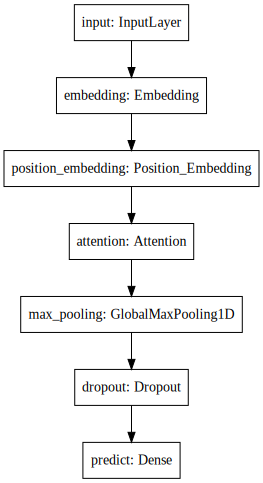

In [23]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [24]:
model.compile(
    loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    3840000     input_1[0][0]                    
__________________________________________________________________________________________________
position__embedding_1 (Position (None, None, 128)    0           embedding_1[0][0]                
__________________________________________________________________________________________________
attention_1 (Attention)         (None, None, 128)    49152       position__embedding_1[0][0]      
                                                                 position__embedding_1[0][0]      
          

In [18]:
from sklearn.model_selection import train_test_split
X_tra, X_val, y_tra, y_val = train_test_split(
    x_train, y_train, test_size=0.3, random_state=233)
roc_auc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

In [21]:
hist = model.fit(
    X_tra,
    y_tra,
    callbacks=[EarlyStopping(patience=5), roc_auc],
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val))

Train on 111699 samples, validate on 47872 samples
Epoch 1/100
  1536/111699 [..............................] - ETA: 13:00 - loss: 0.2412 - acc: 0.9173

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(x_test, batch_size=1024)

submission = pd.read_csv('../input/sample_submission.csv')
submission[target_cols] = y_pred
submission.to_csv('submission.csv', index=False)